In [0]:
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm_notebook as tqdm

In [0]:
PATH = '/content/drive/My Drive/pku-autonomous-driving/'

train = pd.read_csv(PATH + 'train.csv')

test = pd.read_csv(PATH + 'sample_submission.csv')

In [0]:
len(test)

2021

In [0]:
len(train)

4257

In [0]:
!git clone https://github.com/nianticlabs/monodepth2.git
os.chdir('monodepth2')

Cloning into 'monodepth2'...
remote: Enumerating objects: 138, done.
remote: Total 138 (delta 0), reused 0 (delta 0), pack-reused 138
Receiving objects: 100% (138/138), 10.25 MiB | 5.48 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [0]:
from __future__ import absolute_import, division, print_function

import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

In [0]:
test_images = os.listdir('/content/drive/My Drive/pku-autonomous-driving/test')
train_images = os.listdir('/content/drive/My Drive/pku-autonomous-driving/train')
len(test_images)

2021

In [0]:
# model_name = "mono_640x192"
# model_name = "stereo_640x192"
# model_name = 'mono+stereo_640x192'

# model_name = 'mono_1024x320'
# model_name = 'stereo_1024x320'
model_name = 'mono+stereo_1024x320'

# model_name = 'mono_no_pt_640x192'
# model_name = 'stereo_no_pt_640x192'
# model_name = 'mono+stereo_no_pt_640x192'

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval()

DepthDecoder(
  (decoder): ModuleList(
    (0): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (1): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (2): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (3): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (4): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv

In [0]:
def predict(image_path):
    input_image = pil.open(image_path).convert('RGB')

    w, h = input_image.size
    input_image = input_image.crop((0, h/2 - 100, w, h-200))
    original_width, original_height = input_image.size
    # 512×1760
    
    feed_height = loaded_dict_enc['height']
    feed_width = loaded_dict_enc['width']
    # height: 320, width: 1024
    input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

    input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

    with torch.no_grad():
        features = encoder(input_image_pytorch)
        outputs = depth_decoder(features)

    # height: 320, width: 1024
    disp = outputs[("disp", 0)]

    disp_resized = torch.nn.functional.interpolate(disp,
        (original_height, original_width), mode="bilinear", align_corners=False)

    # Saving colormapped depth image
    disp_resized_np = disp_resized.squeeze().cpu().numpy()
    vmax = np.percentile(disp_resized_np, 95)

    plt.figure(figsize=(10, 10))
    plt.subplot(211)
    plt.imshow(input_image)
    # plt.title("Input", fontsize=22)
    plt.axis('off')

    plt.subplot(212)
    plt.imshow(disp_resized_np, cmap='plasma', vmax=vmax)
    # plt.title("Disparity prediction", fontsize=22)
    plt.axis('off')

    return disp_resized_np

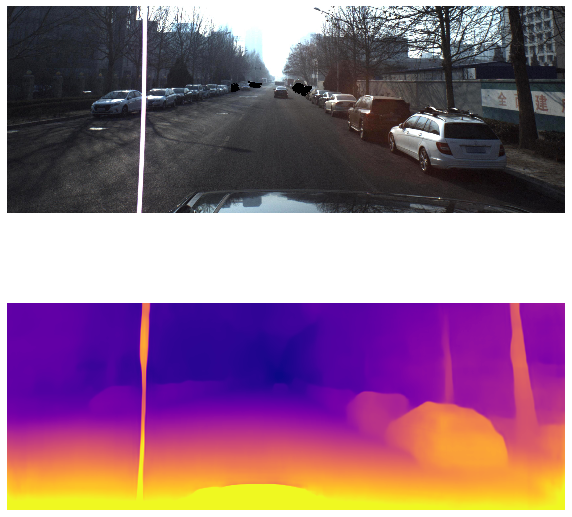

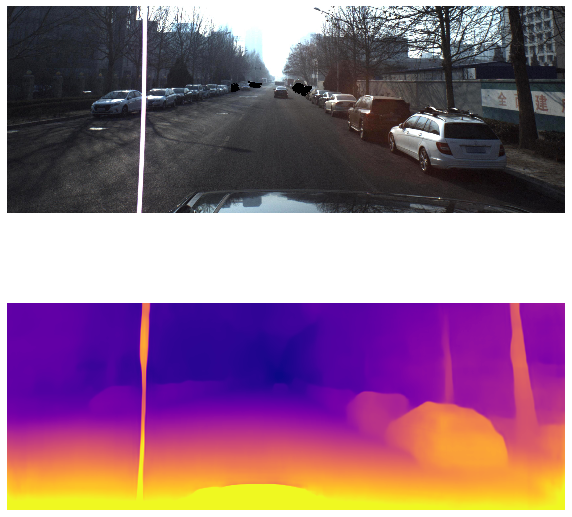

In [0]:
test_idx = 10
# image_path = f'../test_images/{test_images[17]}'
image_path = f'../drive/My Drive/pku-autonomous-driving/test/{test_images[test_idx]}'
out = predict(image_path)

In [0]:
out[1][("disp", 0)].shape

torch.Size([1, 1, 320, 1024])

In [0]:
out[1][("disp", 1)].shape

torch.Size([1, 1, 160, 512])

In [0]:
out[1][("disp", 2)].shape

torch.Size([1, 1, 80, 256])

In [0]:
out[1][("disp", 3)].shape

torch.Size([1, 1, 40, 128])

In [0]:
print(np.amax(out[0]))
print(np.amin(out[0]))

0.14736573
0.0019106948


In [0]:
from math import sin, cos
k = np.array([[2304.5479, 0,  1686.2379],
           [0, 2305.8757, 1354.9849],
           [0, 0, 1]], dtype=np.float32)
def world_2_img(x, y, z):
    p = np.array([x, y, z])
    p = np.dot(k, p)
    x, y = (int(p[0]/p[2]), int(p[1]/p[2]))
    return np.array([x, y])

Predicted: 39.528328525964795	Actual: 57.2911
Predicted: 18.469995725765322	Actual: 16.0025
Predicted: 29.266508098905113	Actual: 23.9126
Predicted: 33.35382541702928	Actual: 29.5115
Predicted: 43.55707108949447	Actual: 40.8017
Predicted: 49.14128633576713	Actual: 47.5887
Predicted: 30.523404515639132	Actual: 21.462
Predicted: 39.40153625145076	Actual: 26.9261
Predicted: 58.76916663893525	Actual: 57.4613
Predicted: 70.21224064839397	Actual: 50.2652
Predicted: 26.23114797318835	Actual: 17.5677


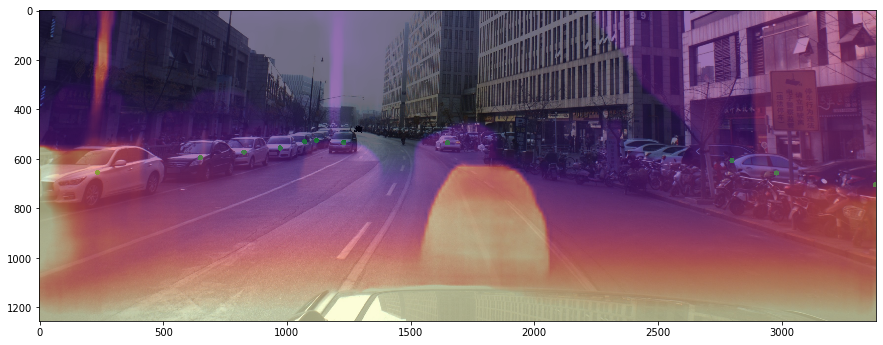

In [0]:
import pandas as pd

train = pd.read_csv('../drive/My Drive/pku-autonomous-driving/train.csv')
train = train.set_index('ImageId')
pred_str = train.loc[train_images[test_idx][:-4]]['PredictionString']

from PIL import Image, ImageDraw
im = pil.open(f'../drive/My Drive/pku-autonomous-driving/train/{train_images[test_idx]}').convert('RGB')
w, h = im.size
im = im.crop((0, h/2 - 100, w, h-200))
draw = ImageDraw.Draw(im)

items = pred_str.split(' ')
model_types, yaws, pitches, rolls, xs, ys, zs = [items[i::7] for i in range(7)]
for yaw, pitch, roll, x, y, z in zip(yaws, pitches, rolls, xs, ys, zs):
    yaw, pitch, roll, x, y, z = [float(x) for x in [yaw, pitch, roll, x, y, z]]
    point = world_2_img(x, y, z)
    point[1] -= h/2 - 100
    print(f'Predicted: {1/out[point[1],point[0]]}\tActual: {z}')
    draw.ellipse((point[0]-10, point[1]-10, point[0]+10, point[1]+10), fill=(0,255,0,255))

fig, axe = plt.subplots(1, figsize=(15,15))
vmax = np.percentile(out, 95)
axe.imshow(out, cmap='magma', vmax=vmax)
axe.imshow(im, alpha=0.4)

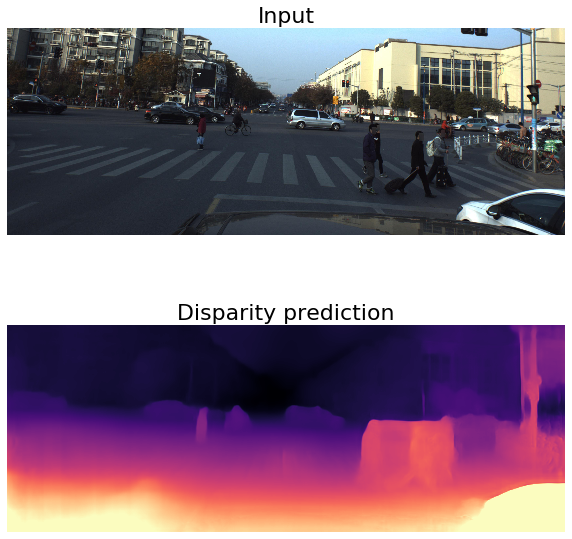

In [0]:
predict(image_path)

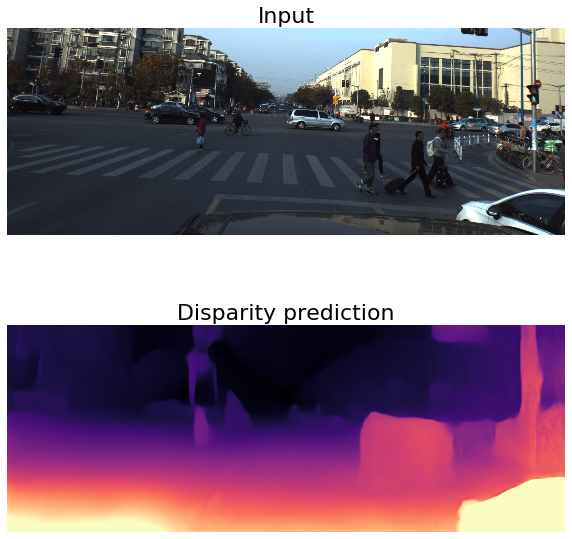

In [0]:
predict(image_path)